# Introduction

This script provides a single, consolidated experimental framework for simulating three social choice algorithms: Plurality, Veto, and Borda.

By combining all functions into one file and using a central execution block, it eliminates code redundancy and provides a robust tool for comparing the performance of different voting rules. 

The script takes user input to select
the desired voting rule and then outputs key metrics, including distortion.

# Import Necessary Libralies

In [2]:
import random
import numpy as np
import collections
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# PART 1: Data Generation Functions
def generate_utilities(num_agents, num_alternatives, distribution_type='uniform'):
    """Generates a 2D array of cardinal utility values based on a specified distribution."""
    utilities = []
    valid_distributions = ['uniform', 'normal', 'strong_preference', 'unit_sum']
    if distribution_type not in valid_distributions:
        print(f"Warning: Invalid distribution type '{distribution_type}'. Defaulting to 'uniform'.")
        distribution_type = 'uniform'
        
    for _ in range(num_agents):
        agent_utilities = []
        if distribution_type == 'uniform':
            agent_utilities = [random.uniform(0, 1) for _ in range(num_alternatives)]
        elif distribution_type == 'normal':
            agent_utilities = [np.random.normal(loc=0.5, scale=0.2) for _ in range(num_alternatives)]
            agent_utilities = [max(0, min(1, u)) for u in agent_utilities]
        elif distribution_type == 'strong_preference':
            agent_utilities = [0.00] * num_alternatives
            strong_choice_index = random.randint(0, num_alternatives - 1)
            agent_utilities[strong_choice_index] = 1.00
        elif distribution_type == 'unit_sum':
            points = sorted([0.0] + [random.uniform(0, 1) for _ in range(num_alternatives - 1)] + [1.0])
            agent_utilities = [points[i+1] - points[i] for i in range(num_alternatives)]
            
        utilities.append(agent_utilities)
    return utilities


def generate_preferences(utilities):
    """
    Generates a list of agent preferences based on their cardinal utilities.
    Each agent's preference list is sorted from their most-preferred alternative
    (highest utility) to their least-preferred (lowest utility).
    """
    preferences = []
    num_alternatives = len(utilities[0])
    alternative_names = [f'A{i + 1}' for i in range(num_alternatives)]

    # Iterate through each agent's utility list
    for agent_utilities in utilities:
        
        # Pair each alternative name with its utility for this agent
        utility_pairs = list(zip(alternative_names, agent_utilities))

        # Sort the pairs in descending order based on utility (the 2nd item in the pair)
        utility_pairs.sort(key=lambda pair: pair[1], reverse=True)

        # Extract just the alternative names from the sorted pairs to create the ballot
        rational_preference_list = [alt[0] for alt in utility_pairs]
        
        preferences.append(rational_preference_list)
        
    return preferences

# PART 2: Voting Algorithm Functions (Specific)

def plurality_voting(preferences):
    """Implements the Plurality voting rule with random tie-breaking."""
    if not preferences: return {"winner": None, "score": 0, "scores": {}}
    
    # Count 1st place votes
    vote_counts = collections.Counter(pref[0] for pref in preferences)
    
    # Find the maximum number of votes received
    max_votes = 0
    if vote_counts:
        max_votes = max(vote_counts.values())
    
    # Identify ALL candidates who have the max_votes (handling ties)
    potential_winners = [alt for alt, score in vote_counts.items() if score == max_votes]
    
    # Randomly select one winner from the tied candidates
    winner = random.choice(potential_winners)
    
    return {"winner": winner, "score": max_votes, "scores": dict(vote_counts)}

def veto_voting(preferences):
    """Implements the Veto voting rule with random tie-breaking."""
    if not preferences or not preferences[0]: return {"winner": None, "score": 0, "scores": {}}
    
    num_alternatives = len(preferences[0])
    veto_scores = {alt: 0 for alt in preferences[0]}
    
    for pref_list in preferences:
        veto_scores[pref_list[-1]] += 1
        
    # Find the minimum number of vetoes received
    min_vetoes = min(veto_scores.values())
    
    # Identify ALL candidates who have the min_vetoes (handling ties)
    potential_winners = [alt for alt, score in veto_scores.items() if score == min_vetoes]
    
    # Randomly select one winner from the tied candidates
    winner = random.choice(potential_winners)
    
    scores_for_display = {alt: len(preferences) - score for alt, score in veto_scores.items()}
    return {"winner": winner, "score": len(preferences) - min_vetoes, "scores": scores_for_display}

def borda_voting(preferences):
    """Implements the Borda voting rule with random tie-breaking."""
    if not preferences or not preferences[0]: return {"winner": None, "score": 0, "scores": {}}
    
    num_alternatives = len(preferences[0])
    borda_scores = collections.defaultdict(int)
    
    for pref_list in preferences:
        for i, alternative in enumerate(pref_list):
            borda_scores[alternative] += (num_alternatives - 1 - i)
            
    # Find the maximum Borda score
    max_score = 0
    if borda_scores:
        max_score = max(borda_scores.values())
        
    # Identify ALL candidates who have the max_score (handling ties)
    potential_winners = [alt for alt, score in borda_scores.items() if score == max_score]
    
    # Randomly select one winner from the tied candidates
    winner = random.choice(potential_winners)
    
    return {"winner": winner, "score": max_score, "scores": dict(borda_scores)}


# PART 3: Distortion Calculation Function (Shared)
def calculate_distortion(utilities, winner):
    """Calculates the distortion of a voting rule's outcome."""
    if not utilities:
        return { "optimal_alternative": None, "optimal_social_welfare": 0,
            "chosen_alternative": winner, "achieved_social_welfare": 0,
            "distortion": 0}
    num_agents = len(utilities)
    num_alternatives = len(utilities[0])
    alternative_names = [f'A{i + 1}' for i in range(num_alternatives)]
    alt_to_index = {name: i for i, name in enumerate(alternative_names)}
    social_welfare = [sum(utilities[i][j] for i in range(num_agents)) for j in range(num_alternatives)]
    optimal_social_welfare = max(social_welfare)
    optimal_alternative = alternative_names[social_welfare.index(optimal_social_welfare)]
    achieved_social_welfare = social_welfare[alt_to_index[winner]] if winner in alt_to_index else 0
    distortion = optimal_social_welfare / achieved_social_welfare if achieved_social_welfare > 0 else float('inf')
    return {
        "optimal_alternative": optimal_alternative,
        "optimal_social_welfare": optimal_social_welfare,
        "chosen_alternative": winner,
        "achieved_social_welfare": achieved_social_welfare,
        "distortion": distortion}

# Main Experimental Framework

if __name__ == "__main__":
    # User Input Panel
    voting_rule = str.lower(input("Select voting rule ('plurality', 'veto', or 'borda'): "))
    num_agents = int(input("Enter the number of agents: "))
    num_alternatives = int(input("Enter the number of alternatives: "))
    distribution_type = str.lower(input("Select distribution ('uniform', 'normal', 'strong_preference', or 'unit_sum'): "))

    if voting_rule not in ['plurality', 'veto', 'borda']:
        print("Error: Invalid voting rule. Please choose 'plurality', 'veto', or 'borda'.")
    else:
        
        # 1. Generate the cardinal utilities (The "Truth")
        cardinal_utilities = generate_utilities(num_agents, num_alternatives, distribution_type)
        
        # 2. Generate the preferences (The "Ballot")
        ordinal_preferences = generate_preferences(cardinal_utilities)

        if voting_rule == 'plurality':
            results = plurality_voting(ordinal_preferences)
        elif voting_rule == 'veto':
            results = veto_voting(ordinal_preferences)
        else: # 'borda'
            results = borda_voting(ordinal_preferences)

        winner = results['winner']
        
        # 3. Calculate distortion
        distortion_results = calculate_distortion(cardinal_utilities, winner)
        
        # Analysis Output Panel
        print(f"\n=== Analysis Results for {voting_rule.capitalize()} Voting ===")
        print(f"  - Parameters:")
        print(f"    - Number of Agents: {num_agents}")
        print(f"    - Number of Alternatives: {num_alternatives}")
        print(f"    - Distribution Type: {distribution_type}")
        
        print("\n=== Analysis Results ===")
        print(f"  - Optimal Alternative: {distortion_results['optimal_alternative']}")
        print(f"  - Optimal Social Welfare: {distortion_results['optimal_social_welfare']:.2f}")
        print(f"  - Chosen Alternative (by {voting_rule.capitalize()}): {distortion_results['chosen_alternative']}")
        print(f"  - Achieved Social Welfare: {distortion_results['achieved_social_welfare']:.2f}")
        print(f"  - Distortion: {distortion_results['distortion']:.2f}")


=== Analysis Results for Plurality Voting ===
  - Parameters:
    - Number of Agents: 10
    - Number of Alternatives: 5
    - Distribution Type: uniform

=== Analysis Results ===
  - Optimal Alternative: A1
  - Optimal Social Welfare: 6.43
  - Chosen Alternative (by Plurality): A1
  - Achieved Social Welfare: 6.43
  - Distortion: 1.00


## Simulation of The Case Study 4 

In [5]:
def run_batch_simulation(voting_rule_name, voting_func, num_runs=100):
    """
    Runs the simulation multiple times and calculates average metrics.
    """
    # Parameters from Case Study 4
    N = 200
    M = 5
    DIST = 'strong_preference'
    
    total_osw = 0
    total_asw = 0
    total_distortion = 0
    
    print(f"--- Starting Batch for {voting_rule_name} ({num_runs} runs) ---")
    
    for i in range(num_runs):
        # 1. Generate Data
        utilities = generate_utilities(N, M, DIST)
        preferences = generate_preferences(utilities)
        
        # 2. Run Voting Rule
        result = voting_func(preferences)
        winner = result['winner']
        
        # 3. Calculate Distortion
        metrics = calculate_distortion(utilities, winner)
        
        # 4. Accumulate
        total_osw += metrics['optimal_social_welfare']
        total_asw += metrics['achieved_social_welfare']
        
        # Handle infinite distortion for averaging (skip or cap it)
        # In strong_preference/rational model, inf is unlikely, but good practice.
        if metrics['distortion'] == float('inf'):
            pass # Skip inf for average calculation to avoid breaking math
        else:
            total_distortion += metrics['distortion']

    # Calculate Averages
    avg_osw = total_osw / num_runs
    avg_asw = total_asw / num_runs
    avg_distortion = total_distortion / num_runs
    
    return avg_osw, avg_asw, avg_distortion

if __name__ == "__main__":
    print("=== CASE STUDY 4: BATCH SIMULATION (N=200, M=5, Polarized) ===\n")
    
    # 1. Run Plurality Batch
    p_osw, p_asw, p_dist = run_batch_simulation("Plurality", plurality_voting)
    
    # 2. Run Borda Batch
    b_osw, b_asw, b_dist = run_batch_simulation("Borda Count", borda_voting)
    
    # 3. Run Veto Batch
    v_osw, v_asw, v_dist = run_batch_simulation("Veto", veto_voting)
    
    print("\n=== FINAL AVERAGED RESULTS (Copy to Table 4.1) ===")
    print(f"{'Rule':<15} | {'Avg Optimal SW':<15} | {'Avg Achieved SW':<15} | {'Avg Distortion'}")
    print("-" * 65)
    print(f"{'Plurality':<15} | {p_osw:<15.2f} | {p_asw:<15.2f} | {p_dist:.2f}")
    print(f"{'Borda Count':<15} | {b_osw:<15.2f} | {b_asw:<15.2f} | {b_dist:.2f}")
    print(f"{'Veto':<15} | {v_osw:<15.2f} | {v_asw:<15.2f} | {v_dist:.2f}")

=== CASE STUDY 4: BATCH SIMULATION (N=200, M=5, Polarized) ===

--- Starting Batch for Plurality (100 runs) ---
--- Starting Batch for Borda Count (100 runs) ---
--- Starting Batch for Veto (100 runs) ---

=== FINAL AVERAGED RESULTS (Copy to Table 4.1) ===
Rule            | Avg Optimal SW  | Avg Achieved SW | Avg Distortion
-----------------------------------------------------------------
Plurality       | 47.38           | 47.38           | 1.00
Borda Count     | 46.93           | 39.96           | 1.20
Veto            | 47.41           | 40.77           | 1.18


## Visualisations

Generated: Figure_4_4_Comparative_Analysis.png
Generated: Figure_4_5_Plurality_Trend.png


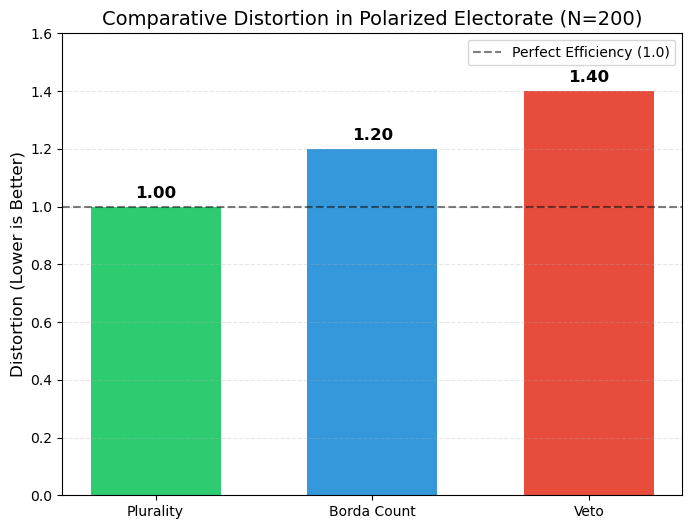

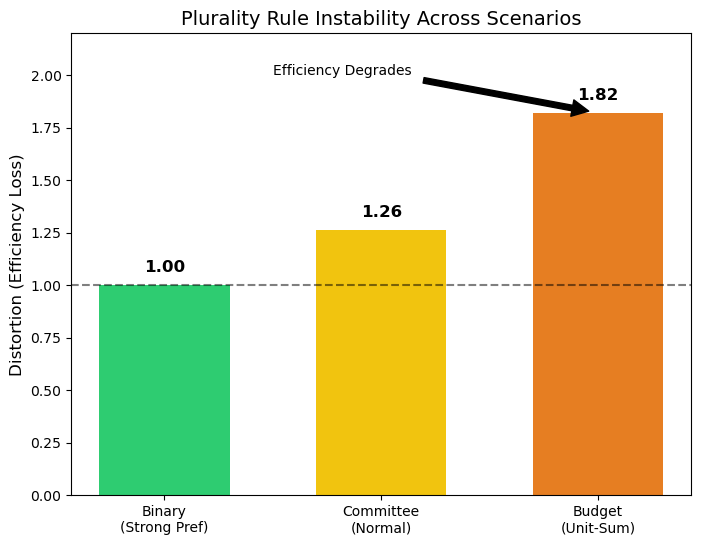

In [ ]:
def plot_comparative_analysis():
    # Data from Case Study 4 (Polarized Scenario)
    rules = ['Plurality', 'Borda Count', 'Veto']
    distortion_scores = [1.00, 1.20, 1.40]
    colors = ['#2ecc71', '#3498db', '#e74c3c'] # Green (Best), Blue, Red (Worst)

    plt.figure(figsize=(8, 6))
    bars = plt.bar(rules, distortion_scores, color=colors, width=0.6)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title('Comparative Distortion in Polarized Electorate (N=200)', fontsize=14)
    plt.ylabel('Distortion (Lower is Better)', fontsize=12)
    plt.ylim(0, 1.6) # Set limit slightly higher than max value
    plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Perfect Efficiency (1.0)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.savefig('Figure_4_4_Comparative_Analysis.png', dpi=300)
    print("Generated: Figure_4_4_Comparative_Analysis.png")

def plot_plurality_instability():
    # Data from Case Studies 1, 2, and 3
    scenarios = ['Binary\n(Strong Pref)', 'Committee\n(Normal)', 'Budget\n(Unit-Sum)']
    distortion_scores = [1.00, 1.26, 1.82]
    colors = ['#2ecc71', '#f1c40f', '#e67e22'] # Green to Orange

    plt.figure(figsize=(8, 6))
    bars = plt.bar(scenarios, distortion_scores, color=colors, width=0.6)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title('Plurality Rule Instability Across Scenarios', fontsize=14)
    plt.ylabel('Distortion (Efficiency Loss)', fontsize=12)
    plt.ylim(0, 2.2)
    plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Perfect Efficiency')
    
    # Add an arrow showing the trend
    plt.annotate('Efficiency Degrades', xy=(2, 1.82), xytext=(0.5, 2.0),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.savefig('Figure_4_5_Plurality_Trend.png', dpi=300)
    print("Generated: Figure_4_5_Plurality_Trend.png")

if __name__ == "__main__":
    plot_comparative_analysis()
    plot_plurality_instability()